# Simulation for power in designing cluster randomized trials
## Agenda

- power analysis

## 参考

- [R-bloggers](https://www.r-bloggers.com/simulation-for-power-in-designing-cluster-randomized-trials/)
- [design effect](https://www.rdatagen.net/post/what-exactly-is-the-design-effect/)
- [pandas cross join](https://www.it-swarm.dev/ja/python/pandasを使用したパフォーマンスデカルト積（cross-join）/807936232/)

## Papers
- [Vierron & Giraudeau](https://link.springer.com/content/pdf/10.1186/1471-2288-9-39.pdf)

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Import

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import nct

from statsmodels.stats.weightstats import DescrStatsW, CompareMeans
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

### 関数

In [5]:
def cartesian_product(*arrays):
    '''
    EXAMPLE
        > cartesian_product(*[np.array([1., 2.]), np.array([2, 3])])
        array([[1., 2.],
               [1., 3.],
               [2., 2.],
               [2., 3.]])
    '''
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)  

## 1. 実験デザインを考える前に

measurement, unit of randomization, and sample sizeといった問題は実験デザインを考える上で重要な要素だが、これらを議論する前にまず「Research Question」を議論する必要がある。

Ronald Fisherの有名なquoteとして、

```
“To consult the statistician after an experiment is finished is often merely to ask him to conduct a post-mortem examination. He can perhaps say what the experiment died of. 
```

ただし、現実にはCOVID-19のように対応が後手に回り組織づくりができなかったり、マンパワーの不足など、理想的な実験環境が作れないまま分析をしなくてならない時がある。

## 2. Data generating process in Python

In [6]:
def independentData(N, prob = 0.5, seed = 42):
    np.random.seed(seed)
    unit_id = np.arange(1, N+1)
    treatment = np.ones(N, dtype = int)
    ind = np.random.permutation(N)[:int(N*prob)]
    treatment[ind] = 0
    df = pd.DataFrame(np.vstack([unit_id, treatment]).T, columns = ['id', 'treatment'])
    return df

def add_outcome(df, variance):
    N = df.shape[0]
    eps = np.random.normal(0, np.sqrt(variance), N)
    return df['treatment'] * 0.8 + eps

def compare_means(x1, x2):
    rct_ttest = CompareMeans(DescrStatsW(x1), 
                         DescrStatsW(x2))
    rct_ttest.ttest_ind()  # defaults two-sided, pooled
    print(rct_ttest.summary())


In [7]:
N = 30*50
df = independentData(N, prob = 0.5)
df['outcome'] = add_outcome(df, variance = 10)
df.head()

,id,treatment,outcome
0,1,1,1.336490
1,2,1,0.790473
2,3,0,-0.275462
3,4,0,2.989649
4,5,1,5.158488


### observed effect size

In [8]:
compare_means(df.loc[df['treatment'] == 1, 'outcome'], df.loc[df['treatment'] == 0, 'outcome'])

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.7793      0.167      4.673      0.000       0.452       1.106


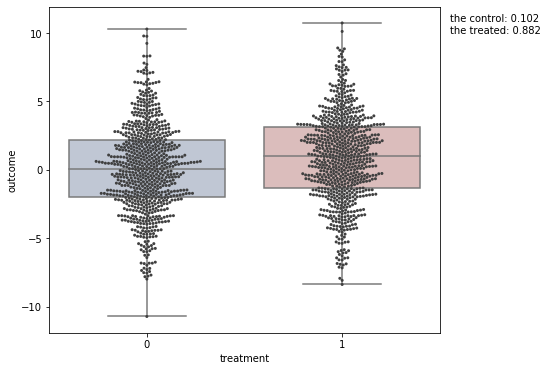

In [9]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="treatment", y="outcome", data=df,
            whis=[0, 100], palette="vlag")
sns.swarmplot(x="treatment", y="outcome", data=df, size=3, color=".25")
ax.text(1.55, 10,'the control: {}\nthe treated: {}'.format(*df.groupby('treatment')['outcome'].mean().values.round(3)), fontsize=10);

### Randomization by site

個人単位ではなくて、その個人が所属するグループでintervention statusがassignされるとする（例：学校単位）。

In [10]:
def clusteredData(K, variance, prob = 0.5, seed = 42):
    np.random.seed(seed)
    
    cluster_id = np.arange(1, K+1)
    treatment = np.ones(K, dtype = int)
    ind = np.random.permutation(K)[:int(K*prob)]
    treatment[ind] = 0
    
    df = pd.DataFrame(np.vstack([cluster_id, treatment]).T, columns = ['cluster_id', 'treatment'])
    df['cluster_effect'] = np.random.normal(0, np.sqrt(variance), K)
    return df

def cartesian_product_multi(*dfs):
    idx = cartesian_product(*[np.ogrid[:len(df)] for df in dfs])
    return pd.DataFrame(
        np.column_stack([df.values[idx[:,i]] for i,df in enumerate(dfs)]))

def add_outcome_cluster(df, variance):
    N = df.shape[0]
    eps = np.random.normal(0, np.sqrt(variance), N)
    return df['treatment'] * 0.8  + df['cluster_effect'] + eps


In [11]:
K = 30
M = 50

df_site = clusteredData(K, variance = 0.5, prob = 0.5)
df_2 = cartesian_product_multi(*[df_site, pd.Series(np.arange(1, M+1))])
df_2.columns = list(df_site.columns) + ['id']
df_2['outcome'] = add_outcome_cluster(df_2, variance = 9.5)

df_2.head()

,cluster_id,treatment,cluster_effect,id,outcome
0,1.0,0.0,-0.302674,1.0,-4.453415
1,1.0,0.0,-0.302674,2.0,-3.016839
2,1.0,0.0,-0.302674,3.0,-3.787271
3,1.0,0.0,-0.302674,4.0,0.111663
4,1.0,0.0,-0.302674,5.0,1.491549


In [12]:
compare_means(df_2.loc[df_2['treatment'] == 1, 'outcome'], df_2.loc[df_2['treatment'] == 0, 'outcome'])

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.9062      0.164      5.541      0.000       0.585       1.227


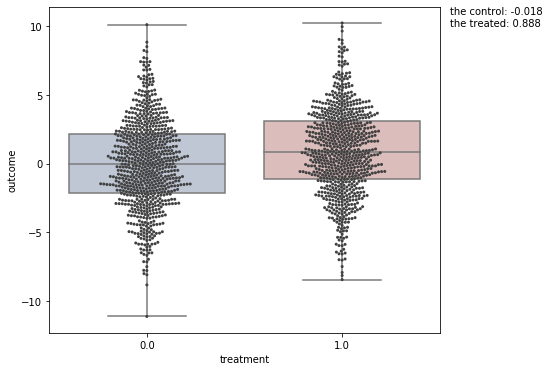

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="treatment", y="outcome", data=df_2,
            whis=[0, 100], palette="vlag")
sns.swarmplot(x="treatment", y="outcome", data=df_2, size=3, color=".25")
ax.text(1.55, 10,'the control: {}\nthe treated: {}'.format(*df_2.groupby('treatment')['outcome'].mean().values.round(3)), fontsize=10);

### Randomization within site

いわゆるstratified random assignmenet

In [14]:
def strata_assignment(df, prob = 0.5):
    K = df.shape[0]
    treatment = np.ones(K)
    ind = np.random.permutation(K)[:int(K*prob)]
    treatment[ind] = 0
    return treatment

In [15]:
K = 30
M = 50

df_site = clusteredData(K, variance = 0.5, prob = 0.5)
df_2 = cartesian_product_multi(*[df_site, pd.Series(np.arange(1, M+1))])
df_2.columns = list(df_site.columns) + ['id']
df_2.head()

,cluster_id,treatment,cluster_effect,id
0,1.0,0.0,-0.302674,1.0
1,1.0,0.0,-0.302674,2.0
2,1.0,0.0,-0.302674,3.0
3,1.0,0.0,-0.302674,4.0
4,1.0,0.0,-0.302674,5.0


In [16]:
df_2['treatment'] = df_2.groupby('cluster_id')['treatment'].transform(strata_assignment)

In [17]:
df_2['outcome'] = add_outcome_cluster(df_2, variance = 9.5)
df_2.head()

,cluster_id,treatment,cluster_effect,id,outcome
0,1.0,1.0,-0.302674,1.0,4.875614
1,1.0,0.0,-0.302674,2.0,-2.061832
2,1.0,0.0,-0.302674,3.0,-2.868166
3,1.0,0.0,-0.302674,4.0,1.150326
4,1.0,1.0,-0.302674,5.0,-1.204740


In [18]:
compare_means(df_2.loc[df_2['treatment'] == 1, 'outcome'], df_2.loc[df_2['treatment'] == 0, 'outcome'])

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      1.0433      0.162      6.448      0.000       0.726       1.361


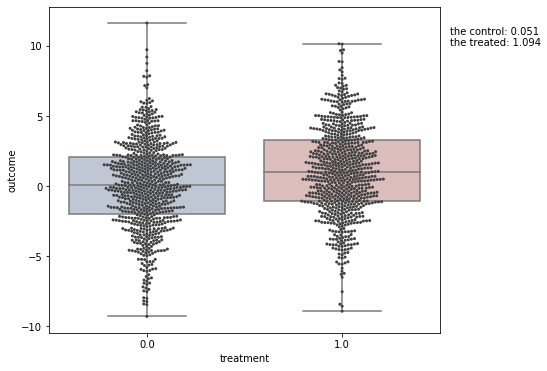

In [19]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="treatment", y="outcome", data=df_2,
            whis=[0, 100], palette="vlag")
sns.swarmplot(x="treatment", y="outcome", data=df_2, size=3, color=".25")
ax.text(1.55, 10,'the control: {}\nthe treated: {}'.format(*df_2.groupby('treatment')['outcome'].mean().values.round(3)), fontsize=10);

## 3. The design effect

for more details, see [Vierron & Giraudeau](https://link.springer.com/content/pdf/10.1186/1471-2288-9-39.pdf).

二つの統計量を考える：

- $\sigma^2_{\Delta_{bc}}$: the variance of the effect sizes under the cluster randomization
- $\sigma^2_{\Delta_{i}}$ : the variance of the effect sizes under the individual randomization 

$$
\sigma^2_{\Delta_{bc}} = \text{Var}(\bar Y_1^{bc} - \bar Y_0^{bc})
$$

$$
\sigma^2_{\Delta_{i}} = \text{Var}(\bar Y_1^{i} - \bar Y_0^{i})
$$

このとき、the design effect $\delta_{bc}$は以下のように定義される：

$$
\delta_{bc} = \frac{\sigma^2_{\Delta_{bc}}}{\sigma^2_{\Delta_{i}} }
$$

### clusterPower

Rで`clusterPower`ライブラリを用いて計算する

In [20]:
sample_size = ro.r('''library(clusterPower)
crtpwr.2mean(m = 50/2, d = 0.8, icc = 0.05, varw = 9.5)
''')
np.array(sample_size)[0].round(3)

17.922

つまり、トータルで約900サンプルサイズ必要ということがわかる。